# Section 3: Experiment 2 – Deep Learning Models

**Environment Setup**

To ensure reproducibility and compatibility across all components of the pipeline, specific library versions were installed at the beginning of the experiment. These versions were selected based on compatibility with TensorFlow 2.15 and the latest releases of NLP-related libraries.

In [ ]:
!pip install numpy==1.26.4 spacy==3.7.2 torchtext==0.16.2 gensim==4.3.3 tensorflow==2.15.0 --quiet


**SpaCy Model Download**

The en_core_web_sm model from spaCy was downloaded to enable tokenization and part-of-speech tagging during preprocessing.

In [ ]:
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
pip install fsspec==2023.9.2


In [ ]:
!pip install datasets

In [ ]:
import numpy as np
import spacy
from datasets import load_dataset
import gensim.downloader as api
from torchtext.vocab import GloVe
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Dropout


**Dataset Loading and Preprocessing**




In [ ]:
# Load dataset
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']


nlp = spacy.load("en_core_web_sm")
stop_words = set(nlp.Defaults.stop_words)

def preprocess(example):
    tokens = [tok.lower() for tok in example['tokens']]
    doc = nlp(" ".join(tokens))
    pos_tags = [token.pos_ for token in doc]
    labels = example['ner_tags'][:len(tokens)]
    return {'tokens': tokens, 'pos': pos_tags, 'labels': labels}


train_processed = [preprocess(e) for e in train_data]
val_processed = [preprocess(e) for e in val_data]
test_processed = [preprocess(e) for e in test_data]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

**Vocabulary Construction and Embedding Preparation**

In [ ]:
#  vocabulary
vocab = set()
for item in train_processed:
    vocab.update(item['tokens'])

word2idx = {word: idx+1 for idx, word in enumerate(sorted(vocab))}
idx2word = {idx: word for word, idx in word2idx.items()}

label2idx = {'O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}
idx2label = {idx: label for label, idx in label2idx.items()}

#  GloVe
from torchtext.vocab import GloVe
import numpy as np

glove_vectors = GloVe(name='840B', dim=300)
embedding_dim = 300
embedding_matrix = np.zeros((len(word2idx)+1, embedding_dim))

for word, idx in word2idx.items():
    if word in glove_vectors.stoi:
        embedding_matrix[idx] = glove_vectors[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


.vector_cache/glove.840B.300d.zip: 2.18GB [06:56, 5.23MB/s]                            
100%|█████████▉| 2196016/2196017 [04:07<00:00, 8879.13it/s]


**Data Encoding **


*   A function encode_data was created to convert tokens and labels into numbers
*   Each token is mapped to its index using word2idx, and each label using label2idx.

*   Sequences are padded to a fixed length of 100 so that all inputs are the same size.
*   If a token or label is not found, it is replaced with 0 (default index).


*   This step prepares the input (X) and output (y) arrays for training the model.











In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def encode_data(data, word2idx, label2idx, max_len=100):
    X = []
    y = []

    for item in data:
        token_ids = [word2idx.get(tok, 0) for tok in item['tokens']]
        label_ids = [label2idx.get(lbl, 0) for lbl in item['labels']]

        X.append(token_ids[:max_len])
        y.append(label_ids[:max_len])

    X = pad_sequences(X, maxlen=max_len, padding='post')
    y = pad_sequences(y, maxlen=max_len, padding='post')

    return X, y

In [ ]:
X_train, y_train = encode_data(train_processed, word2idx, label2idx)
X_val, y_val = encode_data(val_processed, word2idx, label2idx)
X_test, y_test = encode_data(test_processed, word2idx, label2idx)

y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f4f64d6c8058e67ee4589c966ff62d48fad5a66822617daec1161beaa04c6231
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


**Model Preparation and Evaluation Setup **

Imported TensorFlow and other useful libraries for building and evaluating



*   Imported TensorFlow and other useful libraries for building and evaluating
*   Defined a function encode_data() to convert tokens and labels into numbers and pad them to equal length
* Prepared X_train, X_val, and X_test inputs along with their labels.
* Added an extra dimension to y_train and y_val to match model requirements.

**Model Evaluation Function**

* evaluate_deep_model() runs the model on test data to get predictions.
* It compares the predicted labels with the true labels, ignoring padded parts.
*   It prints a detailed classification report.
*   It saves precision, recall, and F1-score into a dictionary called results.



In [ ]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, TimeDistributed, Dense, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

def encode_data(data, word2idx, label2idx, max_len=100):
    X, y = [], []
    for item in data:
        token_ids = [word2idx.get(tok, 0) for tok in item['tokens']]
        label_ids = [label2idx.get(lbl, 0) for lbl in item['labels']]
        X.append(token_ids[:max_len])
        y.append(label_ids[:max_len])
    X = pad_sequences(X, maxlen=max_len, padding='post')
    y = pad_sequences(y, maxlen=max_len, padding='post')
    return X, y

X_train, y_train = encode_data(train_processed, word2idx, label2idx)
X_val, y_val = encode_data(val_processed, word2idx, label2idx)
X_test, y_test = encode_data(test_processed, word2idx, label2idx)

y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]


def evaluate_deep_model(model, data, word2idx, label2idx, idx2label, max_len=100):
    X_test, y_true = encode_data(data, word2idx, label2idx, max_len=max_len)
    y_true = y_true.tolist()
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=-1)

    true_labels, pred_labels = [], []
    for i in range(len(y_true)):
        true_seq, pred_seq = [], []
        for j in range(len(y_true[i])):
            if y_true[i][j] != 0:
                true_seq.append(idx2label[y_true[i][j]])
                pred_seq.append(idx2label[y_pred[i][j]])
        true_labels.append(true_seq)
        pred_labels.append(pred_seq)

    print(f"\nClassification Report:\n{classification_report(true_labels, pred_labels)}")
    return {
        "precision": precision_score(true_labels, pred_labels),
        "recall": recall_score(true_labels, pred_labels),
        "f1_score": f1_score(true_labels, pred_labels)
    }

results = {}


In [ ]:
!pip install tensorflow


Model Training and Evaluation (BiLSTM, BiLSTM+CNN, Tuned BiLSTM)
**Model 1: BiLSTM**

* A basic BiLSTM model was created using pre-trained GloVe embeddings.


*   It uses 128 LSTM units with dropout (0.5) to prevent overfitting.

*   he model was trained for 10 epochs with a batch size of 32.

**Model 2: BiLSTM + CNN**


*   A convolutional layer (Conv1D) was added before the BiLSTM to capture local patterns.


*  The rest of the structure is similar to the BiLSTM model.

*   It also used 10 epochs and a batch size of 32.




**Model 3: Tuned BiLSTM**


* Dropout was reduced to 0.3, and the learning rate was lowered to 0.0005 for better control.


* The batch size was increased to 64 to stabilize training.


* This version showed improved generalization due to hyperparameter tuning.

* After training each model, they were evaluated using the evaluate_deep_model() function.


*  Final precision, recall, and F1-scores for all models were printed for comparison.

In [ ]:


# --- Model 1: BiLSTM ---
model = Sequential()
model.add(Embedding(input_dim=len(word2idx)+1, output_dim=300, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(label2idx), activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training BiLSTM...")
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)
print("\nEvaluating BiLSTM...")
results["BiLSTM"] = evaluate_deep_model(model, test_processed, word2idx, label2idx, idx2label)

# --- Model 2: BiLSTM + CNN ---
cnn_bilstm_model = Sequential()
cnn_bilstm_model.add(Embedding(input_dim=len(word2idx)+1, output_dim=300, weights=[embedding_matrix], input_length=100, trainable=False))
cnn_bilstm_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnn_bilstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
cnn_bilstm_model.add(Dropout(0.5))
cnn_bilstm_model.add(TimeDistributed(Dense(len(label2idx), activation='softmax')))
cnn_bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\nTraining BiLSTM + CNN...")
cnn_bilstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)
print("\nEvaluating BiLSTM + CNN...")
results["BiLSTM+CNN"] = evaluate_deep_model(cnn_bilstm_model, test_processed, word2idx, label2idx, idx2label)

# --- Model 3: Tuned BiLSTM ---
tune_model = Sequential()
tune_model.add(Embedding(input_dim=len(word2idx)+1, output_dim=300, weights=[embedding_matrix], input_length=100, trainable=False))
tune_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
tune_model.add(Dropout(0.3))
tune_model.add(TimeDistributed(Dense(len(label2idx), activation='softmax')))
tune_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\nTraining Tuned BiLSTM...")
tune_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=10)
print("\nEvaluating Tuned BiLSTM...")
results["Tuned BiLSTM"] = evaluate_deep_model(tune_model, test_processed, word2idx, label2idx, idx2label)

# === Step 4: Print Final Summary ===
print("\nFinal Evaluation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1-Score={metrics['f1_score']:.3f}")


Training BiLSTM...
Epoch 1/10
63/63 [==============================] - 7s 26ms/step - loss: 0.4066 - accuracy: 0.8959 - val_loss: 0.2062 - val_accuracy: 0.9237
Epoch 2/10
63/63 [==============================] - 1s 11ms/step - loss: 0.1724 - accuracy: 0.9361 - val_loss: 0.1663 - val_accuracy: 0.9405
Epoch 3/10
63/63 [==============================] - 1s 11ms/step - loss: 0.1423 - accuracy: 0.9468 - val_loss: 0.1594 - val_accuracy: 0.9427
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.1232 - accuracy: 0.9543 - val_loss: 0.1438 - val_accuracy: 0.9474
Epoch 5/10
63/63 [==============================] - 1s 11ms/step - loss: 0.1110 - accuracy: 0.9589 - val_loss: 0.1363 - val_accuracy: 0.9496
Epoch 6/10
63/63 [==============================] - 1s 11ms/step - loss: 0.1004 - accuracy: 0.9626 - val_loss: 0.1360 - val_accuracy: 0.9507
Epoch 7/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0901 - accuracy: 0.9666 - val_loss: 0.1381 - val_accuracy: 0

In [ ]:
results = {}
results["BiLSTM"] = evaluate_deep_model(model, test_processed, word2idx, label2idx, idx2label)
results["BiLSTM+CNN"] = evaluate_deep_model(cnn_bilstm_model, test_processed, word2idx, label2idx, idx2label)
results["Tuned BiLSTM"] = evaluate_deep_model(tune_model, test_processed, word2idx, label2idx, idx2label)


8/8 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

          AC       0.99      0.75      0.85       769
          LF       0.78      0.71      0.74       468

   micro avg       0.90      0.73      0.81      1237
   macro avg       0.89      0.73      0.80      1237
weighted avg       0.91      0.73      0.81      1237

8/8 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

          AC       0.99      0.70      0.82       769
          LF       0.73      0.64      0.68       468

   micro avg       0.88      0.68      0.77      1237
   macro avg       0.86      0.67      0.75      1237
weighted avg       0.89      0.68      0.77      1237

8/8 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

          AC       0.99      0.65      0.79       769
          LF

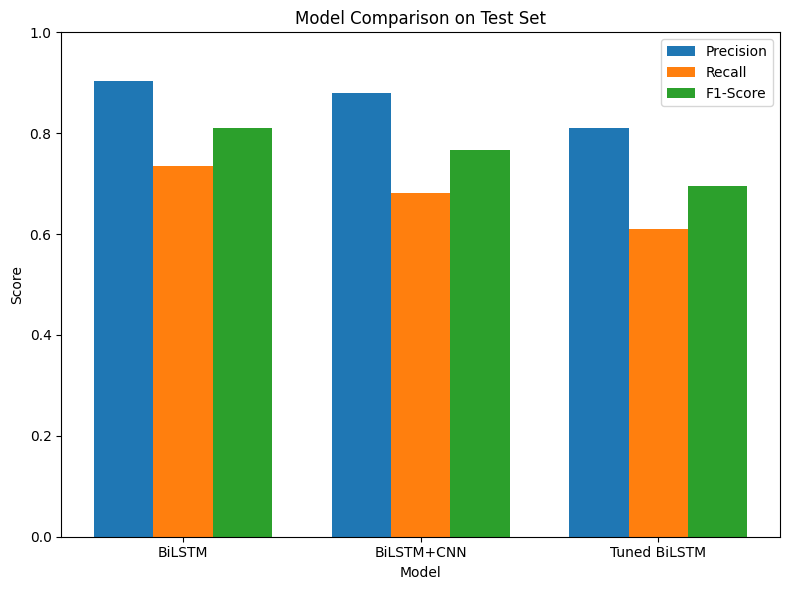

In [ ]:
import matplotlib.pyplot as plt
model_names = list(results.keys())
precision = [results[m]["precision"] for m in model_names]
recall = [results[m]["recall"] for m in model_names]
f1 = [results[m]["f1_score"] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_title('Model Comparison on Test Set')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.savefig("model_comparison.png")  # Save the plot as PNG
plt.show()


**Model Retraining with Callbacks**

*   EarlyStopping stops training early if validation loss doesn’t improve for 3 consecutive epochs.
*   lowers the learning rate by half if validation loss doesn’t improve for 2 epochs.


*  All three models — BiLSTM, BiLSTM+CNN, and Tuned BiLSTM — were retrained using these callbacks
*  The tuned model used a higher batch size (64), while the others used 32.




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Re-train Fine-tuned BiLSTM
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    callbacks=callbacks
)

# Re-train BiLSTM + CNN
cnn_bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=10,
    callbacks=callbacks
)

# Re-train Tuned BiLSTM
tune_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
63/63 [==============================] - 1s 14ms/step - loss: 0.0575 - accuracy: 0.9793 - val_loss: 0.1529 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0509 - accuracy: 0.9817 - val_loss: 0.1566 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0450 - accuracy: 0.9839 - val_loss: 0.1670 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0383 - accuracy: 0.9869 - val_loss: 0.1890 - val_accuracy: 0.9469 - lr: 5.0000e-04
Epoch 1/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0575 - accuracy: 0.9790 - val_loss: 0.1762 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 2/10
63/63 [==============================] - 1s 13ms/step - loss: 0.0527 - accuracy: 0.9806 - val_loss: 0.1541 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 3/10
63/63 [==============================] - 1s 12ms/step - loss:

In [ ]:
results["Fine-tuned BiLSTM"] = evaluate_deep_model(model, test_processed, word2idx, label2idx, idx2label)
results["BiLSTM+CNN"] = evaluate_deep_model(cnn_bilstm_model, test_processed, word2idx, label2idx, idx2label)
results["Tuned BiLSTM"] = evaluate_deep_model(tune_model, test_processed, word2idx, label2idx, idx2label)


8/8 [==============================] - 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

          AC       0.99      0.77      0.87       769
          LF       0.75      0.69      0.72       468

   micro avg       0.89      0.74      0.81      1237
   macro avg       0.87      0.73      0.79      1237
weighted avg       0.90      0.74      0.81      1237

8/8 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

          AC       0.99      0.73      0.84       769
          LF       0.75      0.63      0.69       468

   micro avg       0.89      0.69      0.78      1237
   macro avg       0.87      0.68      0.76      1237
weighted avg       0.90      0.69      0.78      1237

8/8 [==============================] - 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

          AC       0.99      0.73      0.84       769
          LF

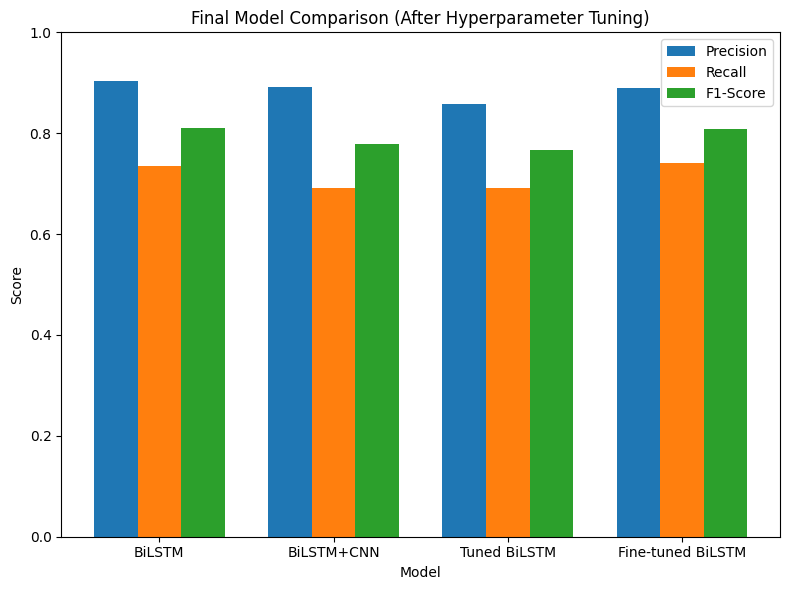

In [ ]:

# Automatically extract metrics from the results dictionary
model_names = list(results.keys())
precision = [results[model]["precision"] for model in model_names]
recall = [results[model]["recall"] for model in model_names]
f1 = [results[model]["f1_score"] for model in model_names]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1, width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.set_title('Final Model Comparison (After Hyperparameter Tuning)')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.savefig("final_model_comparison.png")
plt.show()


**Error Analysis Function**

In [ ]:
def error_analysis(X_test_tokens, y_true, y_pred, idx2label, n_examples=3):
    print("\n--- ERROR ANALYSIS ---")

    for i in range(len(y_true)):
        true_seq = y_true[i]
        pred_seq = y_pred[i]
        tokens = X_test_tokens[i]

        for j in range(len(true_seq)):
            if true_seq[j] != pred_seq[j] and true_seq[j] != 0:
                context = tokens[max(0, j-2): j+3]
                print(f"\nSequence {i}, Token {j}:")
                print("Context     :", context)
                print("True Label  :", idx2label[true_seq[j]])
                print("Pred Label  :", idx2label[pred_seq[j]])

                n_examples -= 1
                if n_examples <= 0:
                    return


In [ ]:
X_test, y_true = encode_data(test_processed, word2idx, label2idx)
y_true = y_true.tolist()
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)
X_tokens = [ex['tokens'] for ex in test_processed]


8/8 [==============================] - 0s 5ms/step


In [ ]:
error_analysis(X_tokens, y_true, y_pred, idx2label)


--- ERROR ANALYSIS ---

Sequence 0, Token 32:
Context     : ['of', 'the', 'lcv', 'is', 'not']
True Label  : B-AC
Pred Label  : O

Sequence 0, Token 51:
Context     : ['via', 'the', 'intracellular', 'multiplication', '(']
True Label  : B-LF
Pred Label  : O

Sequence 0, Token 52:
Context     : ['the', 'intracellular', 'multiplication', '(', 'icm)/defective']
True Label  : I-LF
Pred Label  : O
